In [ ]:
!pip install demoji

In [ ]:
!pip install WordCloud

In [ ]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 6.0MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97712 sha256=875b8bc3da35a9a6bca6e757b193875f405607637717544641005ad01310f760
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
Successfully built pyLDAvis


In [ ]:
import numpy as np
import pandas as pd

# Data Cleaning
import re
import string
import demoji
demoji.download_codes()
from textblob import TextBlob  #SpellCheck 

# Data Pre-processing
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from pprint import pprint
%matplotlib inline
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

# Model Building & Hperparameter Tuning 
from sklearn.feature_extraction.text import CountVectorizer
import spacy
import pyLDAvis.gensim  # don't skip this
import pyLDAvis.sklearn
from sklearn.model_selection import *
from sklearn.decomposition import LatentDirichletAllocation


import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

... OK (Got response in 0.17 seconds)
Writing emoji data to /root/.demoji/codes.json ...
... OK
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/NLP project/DATASET/20201117_230813_covid_tweets_50000.csv')
df.head(5)

,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetcreatedts,retweetcount,text,hashtags
0,KavitaNair,🇺🇸 🌟 Personal Account 🌟 Instagram @thekavitana...,NaN,291,733,7374,2008-09-18 01:08:47,2020-11-17 18:07:31,137,NEW: I just signed an Executive Order to lower...,"[{'text': 'COVID19', 'indices': [131, 139]}]"
1,annaholligan,Foreign correspondent @bbcnews Journalist. Fil...,"The Hague, The Netherlands",8168,23749,18951,2009-01-17 06:58:29,2020-11-17 18:07:31,0,"Dutch bars, cafes and restaurants will remain ...","[{'text': 'COVID19', 'indices': [259, 267]}]"
2,Champlow,Ubisoft⭐️_PLAYER 2019 x Trials Elite x Admin a...,Mordor,284,376,5078,2013-12-05 14:03:36,2020-11-17 18:07:31,0,Happy birthday 🙃\n#Covid_19 https://t.co/vIzzA...,"[{'text': 'Covid_19', 'indices': [17, 26]}]"
3,stshank,"Senior editor, CNET News. I cover browsers, ph...","SF Bay Area, CA",3633,30489,57043,2007-06-05 14:47:23,2020-11-17 18:07:31,0,The area of arctic sea ice that didn't melt be...,[]
4,JoelJeffcoat,NaN,NaN,293,113,19637,2017-04-18 18:30:24,2020-11-17 18:07:31,30,This is where we are. CEOs of the American Hos...,[]


# Data Cleaning 

In [ ]:
# Remove URL

def remove_URL(text):
    url = re.compile(r'http\S+')
    return url.sub(r'',text)

df['text'] = df['text'].apply(lambda x : remove_URL(x))

In [ ]:
df['text'].str.contains("http", "https").value_counts()

False    50000
Name: text, dtype: int64

In [ ]:
# Remove html tags

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

df['text']=df['text'].apply(lambda x : remove_html(x))

In [ ]:
# Remove emojis

def remove_emojis(text):
  new_text = demoji.replace(text, "")
  return new_text

df['text'] = df['text'].apply(lambda x: remove_emojis(x))

In [ ]:
# Remove mentions and hashtag

def remove_mention_hashtag(text):
    text=re.sub(r'@\w+','',text)        # remove mentions
    text=re.sub(r'#\w+','',text)        # remove hashtag
    return text

df['text']=df['text'].apply(lambda x: remove_mention_hashtag(x))

In [ ]:
# Remove Emails

def remove_emails(text):
  email = re.compile(r'\S*@\S*\s?')
  return email.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_emails(x))

In [ ]:
# Remove new line characters

def remove_newline(text):
  newline = re.compile(r'\n+')
  return newline.sub(r'', text)

df['text']=df['text'].apply(lambda x : remove_newline(x))

In [ ]:
# Remove extra white space left while removing stuff

def remove_space(text):
    whitespace_remove = re.compile(r'\s+')
    return whitespace_remove.sub(r' ', text)

df["text"]=df["text"].apply(lambda x: remove_space(x))

# Data Pre-processing

In [ ]:
punct=string.punctuation+'”‘’“'

def clean_text(text):
#Make text lowercase
    text = text.lower()
#remove text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
#remove punctuation   
    text = re.sub(r'[%s]' % re.escape(punct), '', text)    
#remove words containing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    return text

tweets_df_clean = pd.DataFrame(df["text"].apply(lambda x: clean_text(x)))

In [ ]:
# remove stopwords
stopwords = nltk.corpus.stopwords.words("english")
custom_stopwords = ['hi', '&amp;', 'amp', 'amp;', 'got', "it's", 'it’s', "i'm", 'im', 'want', 'like', '$', '@']
for i in custom_stopwords:
    stopwords.append(i)

def remove_stopwords(text):
    return " ".join(word for word in str(text).split() if word not in stopwords)
    
tweets_df_clean['text']=tweets_df_clean['text'].apply(lambda x: remove_stopwords(x))

In [ ]:
# # Spelling Correction

# def spellCorrection(text):
#   new_text = TextBlob(text)
#   spell_corrected_text = new_text.correct()
#   return spell_corrected_text

# tweets_df_clean["text"] = tweets_df_clean["text"].apply(lambda x: spellCorrection(x))

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Tokenization
tweets_df_clean["text"] = tweets_df_clean["text"].apply(word_tokenize)

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
# Lemmatization 
def lemmatizing(text):
    lemmatizer =WordNetLemmatizer()
    return [lemmatizer.lemmatize(word) for word in text]

tweets_df_clean["text"] = tweets_df_clean["text"].apply(lambda x: lemmatizing(x))

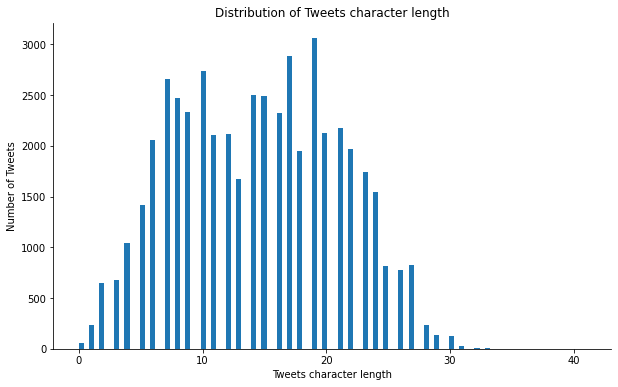

In [ ]:
plt.figure(figsize=(10,6))
doc_lens = [len(d) for d in tweets_df_clean.text]
plt.hist(doc_lens, bins = 100)
plt.title('Distribution of Tweets character length')
plt.ylabel('Number of Tweets')
plt.xlabel('Tweets character length')
sns.despine();

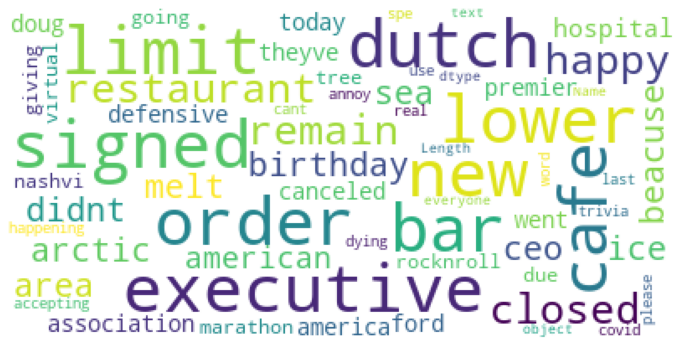

In [ ]:
mpl.rcParams['figure.figsize']=(12.0,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=500,
                          max_font_size=40, 
                          random_state=100
                         ).generate(str(tweets_df_clean.text))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show();

In [ ]:
# Flatten tweets
flat_list = [item for sublist in tweets_df_clean.text for item in sublist]

# CountVectorize
vectorizer = CountVectorizer(
analyzer='word',       
min_df=3, # minimum required occurences of a word 
token_pattern='[a-zA-Z0-9]{3,}', # num chars > 3
max_features=5000, # max number of unique words
                            )
data_matrix = vectorizer.fit_transform(flat_list)

sum_words = data_matrix.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[:20]

[('people', 5882),
 ('case', 5666),
 ('new', 4984),
 ('vaccine', 4852),
 ('pandemic', 3757),
 ('death', 3644),
 ('mask', 3374),
 ('one', 3039),
 ('covid', 2954),
 ('need', 2899),
 ('help', 2714),
 ('today', 2689),
 ('health', 2657),
 ('world', 2611),
 ('test', 2593),
 ('get', 2475),
 ('senate', 2355),
 ('coronavirus', 2300),
 ('virus', 2203),
 ('say', 2157)]

-------
#### Baseline model - Version 1:

In [ ]:
# LDA
lda_model = LatentDirichletAllocation(
n_components=10, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_matrix) 

In [ ]:
# Create topic distance visualization 
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_model, data_matrix, vectorizer, mds='tsne')

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
0      32.420952   8.115230       1        1  10.254638
4       0.648955  71.707100       2        1  10.183914
3      71.019684   9.971006       3        1  10.173947
1       3.785981  33.185135       4        1  10.155483
6     -42.666500  -9.222070       5        1  10.013403
7      -3.621689 -43.526516       6        1   9.984482
9      -3.632402  -4.171708       7        1   9.941094
2     -36.584400  35.804413       8        1   9.810516
5      44.391380  50.615383       9        1   9.751410
8      40.235809 -31.591665      10        1   9.731114, topic_info=           Term         Freq        Total Category  logprob  loglift
3178     people  6182.000000  6182.000000  Default  30.0000  30.0000
612        case  5518.000000  5518.000000  Default  29.0000  29.0000
2908        new  5286.000000  5286.000000  Default  28.0000  28.0000
4735    vaccine  4879.000000  4879.000000  Default  27.0000  27.0000
1079      death  3814.000000  3814.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
2333      issue   646.844034   647.737249  Topic10  -4.5771   2.3285
714        city   626.986179   627.879394  Topic10  -4.6082   2.3284
2555       live   600.798873   601.692088  Topic10  -4.6509   2.3284
2233  infection   532.087685   532.980900  Topic10  -4.7724   2.3282
656   challenge   523.056014   523.949229  Topic10  -4.7895   2.3281

[330 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4         3  0.998783       able
30        6  0.998863  according
40        7  0.998552     across
115       1  0.999019        ago
155       1  0.999174      alone
...     ...       ...        ...
4945      4  0.997756      worse
4952      2  0.998831      would
4975      1  0.999535       year
4980      5  0.999212        yet
4988      3  0.998037      youre

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 2, 7, 8, 10, 3, 6, 9])

In [ ]:
for i,topic in enumerate(lda_model.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['died', 'hospital', 'work', 'exposure', 'government', 'due', 'american', 'number', 'year', 'help']


Top 10 words for topic #1:
['outbreak', 'second', 'parton', 'effective', 'data', 'care', 'market', 'still', 'day', 'vaccine']


Top 10 words for topic #2:
['another', 'home', 'staff', 'spread', 'birthday', 'take', 'school', 'one', 'death', 'people']


Top 10 words for topic #3:
['life', 'even', 'positive', 'make', 'time', 'virus', 'test', 'covid', 'mask', 'case']


Top 10 words for topic #4:
['report', 'back', 'safe', 'republican', 'please', 'wear', 'patient', 'dont', 'say', 'pandemic']


Top 10 words for topic #5:
['within', 'lost', 'impact', 'early', 'response', 'also', 'dolly', 'many', 'trump', 'today']


Top 10 words for topic #6:
['thanksgiving', 'research', 'next', 'information', 'texas', 'month', 'protect', 'million', 'get', 'senate']


Top 10 words for topic #7:
['around', 'think', 'restriction', 'thing', 'november', 'rate', 'tested', 'via', 'public',

### K =  8

In [ ]:
# LDA
lda_model_8 = LatentDirichletAllocation(
n_components=8, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model_8.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model_8.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['care', 'first', 'patient', 'american', 'state', 'still', 'day', 'year', 'family', 'coronavirus']


Top 10 words for topic #1:
['call', 'next', 'leader', 'nearly', 'daily', 'may', 'also', 'effective', 'government', 'due']


Top 10 words for topic #2:
['republican', 'let', 'died', 'spread', 'birthday', 'take', 'make', 'help', 'pandemic', 'people']


Top 10 words for topic #3:
['world', 'dont', 'time', 'virus', 'test', 'covid', 'mask', 'death', 'vaccine', 'case']


Top 10 words for topic #4:
['would', 'last', 'news', 'country', 'back', 'safe', 'hospital', 'market', 'say', 'health']


Top 10 words for topic #5:
['impact', 'restriction', 'gathering', 'way', 'know', 'second', 'dolly', 'trump', 'today', 'new']


Top 10 words for topic #6:
['month', 'report', 'study', 'testing', 'tested', 'protect', 'million', 'get', 'one', 'need']


Top 10 words for topic #7:
['around', 'crisis', 'november', 'thank', 'parton', 'rate', 'public', 'week', 'number', 'senate']




### K = 9

In [ ]:
# LDA
lda_model_9 = LatentDirichletAllocation(
n_components=9, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model_9.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model_9.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['protect', 'work', 'exposure', 'due', 'american', 'still', 'day', 'year', 'trump', 'senate']


Top 10 words for topic #1:
['team', 'must', 'mouthwash', 'senator', 'back', 'another', 'effective', 'market', 'make', 'new']


Top 10 words for topic #2:
['staff', 'many', 'community', 'birthday', 'take', 'million', 'patient', 'one', 'need', 'people']


Top 10 words for topic #3:
['let', 'hospital', 'week', 'even', 'time', 'virus', 'test', 'covid', 'mask', 'case']


Top 10 words for topic #4:
['county', 'report', 'news', 'safe', 'please', 'wear', 'positive', 'dont', 'say', 'vaccine']


Top 10 words for topic #5:
['may', 'would', 'know', 'dolly', 'republican', 'died', 'government', 'health', 'today', 'pandemic']


Top 10 words for topic #6:
['leader', 'texas', 'also', 'keep', 'total', 'study', 'school', 'number', 'get', 'help']


Top 10 words for topic #7:
['nearly', 'thing', 'social', 'parton', 'tested', 'via', 'public', 'data', 'coronavirus', 'death']


Top 10 wor

### k = 3

In [ ]:
# LDA
lda_model_3 = LatentDirichletAllocation(
n_components=3, # Number of topics
learning_method='online',
random_state=20,       
n_jobs = -1  # Use all available CPUs
                                     )
lda_output = lda_model_3.fit_transform(data_matrix)  

In [ ]:
for i,topic in enumerate(lda_model_3.components_):
    print(f'Top 10 words for topic #{i}:')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['year', 'family', 'trump', 'say', 'coronavirus', 'senate', 'help', 'health', 'covid', 'mask']


Top 10 words for topic #1:
['even', 'dont', 'time', 'virus', 'test', 'today', 'death', 'vaccine', 'new', 'case']


Top 10 words for topic #2:
['first', 'patient', 'positive', 'make', 'number', 'get', 'one', 'need', 'pandemic', 'people']




--------

#### Baseline model - Version 2

In [ ]:
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [ ]:
# Create a dictionary of tokens
id2word = Dictionary(tweets_df_clean["text"])

# Create a corpus object. Term document frequency
corpus = [id2word.doc2bow(token) for token in tweets_df_clean["text"]]

# Base LDA model 
lda_model_2 = LdaMulticore(
num_topics=10, # Number of topics
corpus = corpus,
id2word = id2word, 
random_state=20,      
passes = 10,
per_word_topics=True
)


In [ ]:
# Print the Keyword in the 10 topics

print("Topics found via LDA:")
pprint(lda_model_2.print_topics())
doc_lda = lda_model_2[corpus]

Topics found via LDA:
[(0,
  '0.017*"test" + 0.013*"covid" + 0.011*"peopl" + 0.011*"school" + '
  '0.010*"famili" + 0.009*"amp" + 0.009*"help" + 0.007*"dont" + 0.007*"pleas" '
  '+ 0.007*"communiti"'),
 (1,
  '0.018*"use" + 0.017*"american" + 0.016*"million" + 0.015*"die" + '
  '0.014*"video" + 0.013*"new" + 0.013*"make" + 0.013*"put" + 0.012*"get" + '
  '0.012*"brief"'),
 (2,
  '0.022*"year" + 0.016*"birthday" + 0.015*"first" + 0.014*"case" + '
  '0.013*"happi" + 0.012*"us" + 0.011*"vaccin" + 0.011*"hope" + 0.010*"peopl" '
  '+ 0.009*"dont"'),
 (3,
  '0.066*"case" + 0.045*"death" + 0.035*"new" + 0.024*"report" + 0.017*"total" '
  '+ 0.015*"world" + 0.015*"posit" + 0.013*"respons" + 0.011*"number" + '
  '0.011*"day"'),
 (4,
  '0.009*"today" + 0.009*"make" + 0.009*"pandem" + 0.009*"lot" + 0.008*"know" '
  '+ 0.008*"good" + 0.008*"challeng" + 0.008*"news" + 0.007*"stop" + '
  '0.007*"virus"'),
 (5,
  '0.071*"vaccin" + 0.026*"moderna" + 0.022*"coronavirus" + 0.021*"effect" + '
  '0.020*"d

In [ ]:
# Compute Perplexity 
base_perplexity = lda_model_2.log_perplexity(corpus)
print("\nPerplexity: ", base_perplexity)

# Compute Coherence Score
coherence_model = CoherenceModel(model = lda_model_2, texts = tweets_df_clean["text"],
                                 coherence = "c_v")
coherence_lda_model_base = coherence_model.get_coherence()
print("\nCoherence Score: ", coherence_lda_model_base)


Perplexity:  -7.559040927129073

Coherence Score:  0.43162718761210794


In [ ]:
# Visualize the topics

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model_2, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.027705 -0.082832       1        1  15.078655
0     -0.060505 -0.079028       2        1  12.745092
8     -0.053332 -0.044241       3        1  12.088196
3      0.101690 -0.140617       4        1   9.759813
2     -0.059515  0.100108       5        1   9.019704
4      0.002274 -0.089948       6        1   8.787347
5      0.323930  0.206965       7        1   8.486260
9     -0.083871 -0.074565       8        1   8.218776
1      0.024222 -0.049570       9        1   8.043130
6     -0.222598  0.253729      10        1   7.773026, topic_info=       Term         Freq        Total Category  logprob  loglift
60   vaccin  5164.000000  5164.000000  Default  30.0000  30.0000
137    case  6216.000000  6216.000000  Default  29.0000  29.0000
202   senat  3615.000000  3615.000000  Default  28.0000  28.0000
139   death  4021.000000  4021.000000  Default  27.0000  27.0000
81      amp  5882.000000  5882.000000  Default  26.0000  26.0000
..      ...          ...          ...      ...      ...      ...
480   futur   273.583630   436.477869  Topic10  -5.3400   2.0874
192    call   397.674787  1211.291217  Topic10  -4.9660   1.4407
473    need   508.970769  3112.579415  Topic10  -4.7192   0.7437
341      us   412.779814  3122.409742  Topic10  -4.9287   0.5311
186   world   376.886985  1814.283187  Topic10  -5.0197   0.9830

[647 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
971       1  0.998564      abl
4505      6  0.992245     abus
2076      9  0.992731  acceler
122       4  0.148152       ad
122       5  0.848737       ad
...     ...       ...      ...
699       6  0.174236        –
699      10  0.622160        –
3123      1  0.995550        •
4215      1  0.070779       ⁦⁩
4215      3  0.924295       ⁦⁩

[1184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 1, 9, 4, 3, 5, 6, 10, 2, 7])

-------

# Hyperparameter Tuning

### Grid Search -> For baseline model version 1

In [ ]:
# Define Search Param
search_params = {'n_components': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_matrix)
GridSearchCV(cv=None, error_score='raise',
             estimator=LatentDirichletAllocation(batch_size=128, 
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1, 
                                                 learning_decay=0.7, 
                                                 learning_method=None,
                                                 learning_offset=10.0, 
                                                 max_doc_update_iter=100, 
                                                 max_iter=10,
                                                 mean_change_tol=0.001, 
                                                 n_components=10, 
                                                 n_jobs=1,
                                                 perp_tol=0.1, 
                                                 random_state=None,
                                                 topic_word_prior=None, 
                                                 total_samples=1000000.0, 
                                                 verbose=0),
             iid=True, n_jobs=1,
             param_grid={'n_topics': [10, 15, 20, 30], 
                         'learning_decay': [0.5, 0.7, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
             scoring=None, verbose=0)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_matrix))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 10}
Best Log Likelihood Score:  -17117.530889266178
Model Perplexity:  852.8044897512298


-------
### Grid Search -> For baseline model version *2*

In [ ]:
# supporting function

def compute_coherence_values(corpus, dictionary, k, a, b):
    lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=20,
                                           passes=10,
                                           alpha=a,
                                           eta=b,
                                           per_word_topics=True)
    
    coherence_model_lda = CoherenceModel(model=lda_model_2, texts=tweets_df_clean["text"], dictionary=id2word, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [ ]:
import tqdm

grid = {}
grid['Validation_Set'] = {}

# Topics range
min_topics = 2
max_topics = 11
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

# Alpha parameter
alpha = list(np.arange(0.01, 1, 0.3))
alpha.append('symmetric')
alpha.append('asymmetric')

# Beta parameter
beta = list(np.arange(0.01, 1, 0.3))
beta.append('symmetric')

# Validation sets
num_of_docs = len(corpus)
corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
               gensim.utils.ClippedCorpus(corpus, int(num_of_docs*0.75)), 
               corpus]
corpus_title = ['75% Corpus', '100% Corpus']
model_results = {'Validation_Set': [],
                 'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []
                }

# Can take a long time to run
if 1 == 1:
    pbar = tqdm.tqdm(total=100)
    # iterate through validation corpuses
    for i in range(len(corpus_sets)):
        # iterate through number of topics
        for k in topics_range:
            # iterate through alpha values
            for a in alpha:
                # iterare through beta values
                for b in beta:
                    # get the coherence score for the given parameters
                    cv = compute_coherence_values(corpus=corpus_sets[i], 
                                                  dictionary=id2word, 
                                                  k=k, 
                                                  a=a, 
                                                  b=b)
                    # Save the model results
                    model_results['Validation_Set'].append(corpus_title[i])
                    model_results['Topics'].append(k)
                    model_results['Alpha'].append(a)
                    model_results['Beta'].append(b)
                    model_results['Coherence'].append(cv)
                    
                    pbar.update(1)

    pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
    pbar.close()

  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)
225it [11:54:00, 181.55s/it]

In [ ]:
tuning_results=pd.read_csv("lda_tuning_results.csv")
tuning_results

In [ ]:
lda_model_2 = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics= , 
                                           random_state=20,
                                           passes=10,
                                           alpha= ,
                                           eta=  )